# Project 2 - LaMaH dataset

## Basic setup

In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from util_functions import get_prepare_data, shift_values, cv_score_average
from deeplearning_util import TimeSeriesDataset, train_model, descale, print_loss_metrics, predict, reset_models

from tqdm import tqdm
import random

/home/czfire/.local/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MIN_DATA_SAMPLE = 1
MAX_DATA_SAMPLE = 852 # 882
DATA_SET_SIZE = 882

In [3]:
import os

Data_path = "./dataset/A_basins_total_upstrm/2_timeseries/hourly/"

in_dir = os.listdir(Data_path)
files = [f"ID_{id}.csv" for id in range(MIN_DATA_SAMPLE, DATA_SET_SIZE + 1)]

id_blacklist = []

for file in files:
    if file not in in_dir:
        id_blacklist.append(int(file[len("ID_"):-len(".csv")]))

print(id_blacklist)

[31, 146, 353, 362, 365, 369, 400, 417, 418, 419, 420, 421, 424, 425, 427, 502, 522, 727, 745, 765, 775, 781, 794]


https://stackoverflow.com/questions/61300023/how-to-combine-static-features-with-time-series-in-forecasting

https://towardsdatascience.com/multi-step-time-series-forecasting-with-xgboost-65d6820bec39

In [4]:
seed_number = 2022
rng = np.random.default_rng(seed=seed_number)
id_list = rng.integers(low=MIN_DATA_SAMPLE, high=MAX_DATA_SAMPLE, size=100) # We can only take 100 samples from the the timeseries data. Therefor we generate 100 random integers from 1 to 882

for index, value in enumerate(id_list):
    while value in id_blacklist or value in id_list:
        value = random.randint(MIN_DATA_SAMPLE, MAX_DATA_SAMPLE)
    
    id_list[index] = value

file_names = [f"ID_{id}.csv" for id in id_list]
models = ["xgb", "RandomForrest", "DecisionTree", "LinearRegression"] # I removed SGD from this list, as it has an absurdly high error number
tss = TimeSeriesSplit(n_splits=5)

In [5]:
test_data_id_list = range(MAX_DATA_SAMPLE, DATA_SET_SIZE + 1)
print(list(test_data_id_list))

[852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882]


## Non deep learning methods:

In [6]:
scores = {}

n_epochs = 1

for epoch in range(n_epochs):
    for file_name in tqdm(file_names):
        df = get_prepare_data(Data_path=Data_path, filename=file_name, cut_data=True)
        df_shifted = shift_values(df=df)

        df_shifted = df_shifted.select_dtypes(exclude=["datetime64[ns]"])
        
        features = list(df_shifted.columns)
        features.remove("prec")
        target = "prec"
        
        scores_temp = {}
        for model in models:
            scores_temp[model] = cv_score_average(df_shifted, model, tss, features, target)
        scores[file_name] = scores_temp

100%|██████████| 100/100 [07:56<00:00,  4.77s/it]


Final scores: {'XGB': 0.7398088118959585, 'RandomForrest': 0.3858272955611096, 'DecisionTree': 0.5116769814378339, 'LinearRegression': 0.346075043155653}


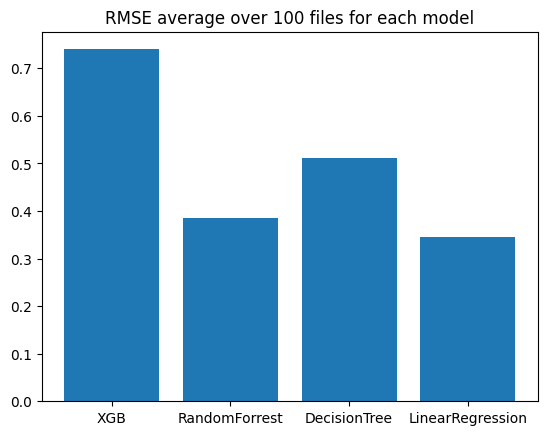

In [7]:
xgb_scores = []
rf_scores = []
dec_tree_scores = []
lin_reg_scores = []

for filename in file_names:
    xgb_scores.append(scores[file_name]["xgb"])
    rf_scores.append(scores[file_name]["RandomForrest"])
    dec_tree_scores.append(scores[file_name]["DecisionTree"])
    lin_reg_scores.append(scores[file_name]["LinearRegression"])

finals_scores = {"XGB": np.average(xgb_scores), "RandomForrest": np.average(rf_scores), "DecisionTree": np.average(dec_tree_scores), "LinearRegression": np.average(lin_reg_scores)}
print("Final scores:", finals_scores)

_ = plt.bar(*zip(*finals_scores.items()))
_ = plt.title("RMSE average over 100 files for each model")

--------------

# Deep learning

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # I get some weird userwarnings when using RNN 

https://towardsdatascience.com/multivariate-time-series-forecasting-with-deep-learning-3e7b3e2d2bcf

In [9]:
parameters = {
    'train_frac' : 0.5,
    'sequence_length' : 3,
    'batch_size' : 1024,
    'n_epochs' : 20,
    'n_epochs_stop' : 5,
    'background_data_size' : 900,
    'test_sample_size' : 100,
    "path" : "./"
}

## Model for everything combined

In [ ]:
scores_deeplearning = {}

for file_name in tqdm(file_names):
    df = get_prepare_data(Data_path=Data_path, filename=file_name, cut_data=False)
    features = list(df.columns)
    features.remove("prec")

    scores_lstm = []
    scores_rnn = []

    scaler = MinMaxScaler()
    scaler = scaler.fit(df)

    for train_idx, val_idx in tss.split(df):    
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train_scaled = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
        test_scaled = pd.DataFrame(scaler.transform(test), index=train.index, columns=train.columns)

        train_model(train_scaled, test_scaled, features, parameters, model_name="LSTM")
        pred_lstm, truth_lstm = predict(test_scaled, parameters, features, scaler, model_name="LSTM")
        scores_lstm.append(mean_squared_error(pred_lstm.tolist(), truth_lstm.tolist(), squared=False))
        
        train_model(train_scaled, test_scaled, features, parameters, model_name="GRU")
        pred_rnn, truth_rnn = predict(test_scaled, parameters, features, scaler, model_name="GRU")
        scores_rnn.append(mean_squared_error(pred_rnn.tolist(), truth_rnn.tolist(), squared=False))
        break

    scores_deeplearning[file_name] = {"LSTM": np.average(scores_lstm), "RNN": np.average(scores_rnn)}

Final scores: {'LSTM': 0.7752491767536225, 'RNN': 0.8512735892249261}


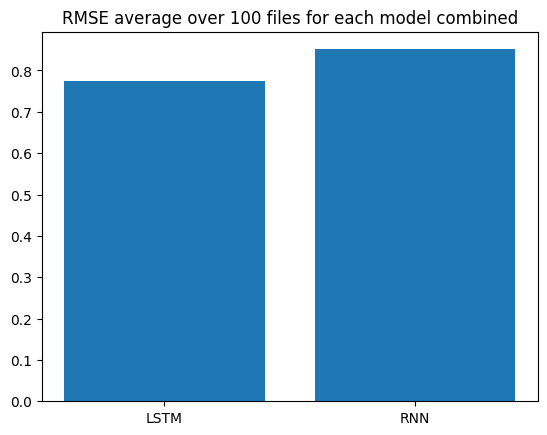

In [9]:
lstm_scores = []
rnn_scores = []
for file_name in file_names:
    lstm_scores.append(scores_deeplearning[file_name]["LSTM"])
    rnn_scores.append(scores_deeplearning[file_name]["RNN"])

finals_scores = {"LSTM": np.average(lstm_scores), "RNN": np.average(rnn_scores)}
print("Final scores:", finals_scores)

_ = plt.bar(*zip(*finals_scores.items()))
_ = plt.title("RMSE average over 100 files for each model combined")

In [10]:
# Add predictions for 30 random files in the future
# but that's already done

## Model for each file (location)

In [ ]:
# To make sure we have a blank new model
reset_models()

scores_deeplearning = {}

for file_name in tqdm(file_names):
    df = get_prepare_data(Data_path=Data_path, filename=file_name, cut_data=False)
    features = list(df.columns)
    features.remove("prec")

    scores_lstm = []
    scores_rnn = []

    scaler = MinMaxScaler()
    scaler = scaler.fit(df)

    for train_idx, val_idx in tss.split(df):    
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train_scaled = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
        test_scaled = pd.DataFrame(scaler.transform(test), index=train.index, columns=train.columns)

        train_model(train_scaled, test_scaled, features, parameters, model_name="LSTM", create_new_model=True)
        pred_lstm, truth_lstm = predict(test_scaled, parameters, features, scaler, model_name="LSTM")
        scores_lstm.append(mean_squared_error(pred_lstm.tolist(), truth_lstm.tolist(), squared=False))
        
        train_model(train_scaled, test_scaled, features, parameters, model_name="GRU", create_new_model=True)
        pred_rnn, truth_rnn = predict(test_scaled, parameters, features, scaler, model_name="GRU")
        scores_rnn.append(mean_squared_error(pred_rnn.tolist(), truth_rnn.tolist(), squared=False))
        break

    scores_deeplearning[file_name] = {"LSTM": np.average(scores_lstm), "RNN": np.average(scores_rnn)}

Final scores: {'LSTM': 0.8249540550282899, 'RNN': 0.9118109721294909}


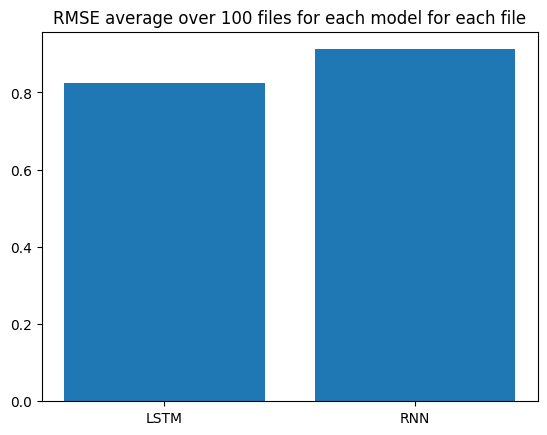

In [12]:
lstm_scores = []
rnn_scores = []
for file_name in file_names:
    lstm_scores.append(scores_deeplearning[file_name]["LSTM"])
    rnn_scores.append(scores_deeplearning[file_name]["RNN"])

finals_scores = {"LSTM": np.average(lstm_scores), "RNN": np.average(rnn_scores)}
print("Final scores:", finals_scores)

_ = plt.bar(*zip(*finals_scores.items()))
_ = plt.title("RMSE average over 100 files for each model for each file")

# Experimenting with features

Even though the most performant model out of the bos is RNN, I don't think it can outperform the LSTM if properly optimalised

In [6]:
# Well, we need to restructure the code to allow parameter optimization :/

parameters = {
    'train_frac' : 0.5,
    'sequence_length' : 3,
    'batch_size' : 1024,
    'n_epochs' : 20,
    'n_epochs_stop' : 5,
    'background_data_size' : 900,
    'test_sample_size' : 100,
    "path" : "./"
}

In [7]:
def get_performance(model_parameters):
    scores_deeplearning = {}
    scores = []

    for file_name in tqdm(file_names[:5]):
        df = get_prepare_data(Data_path=Data_path, filename=file_name, cut_data=False)
        features = list(df.columns)
        features.remove("prec")

        scores_lstm = []

        scaler = MinMaxScaler()
        scaler = scaler.fit(df)

        for train_idx, val_idx in tss.split(df):    
            train = df.iloc[train_idx]
            test = df.iloc[val_idx]
            train_scaled = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
            test_scaled = pd.DataFrame(scaler.transform(test), index=train.index, columns=train.columns)

            train_model(train_scaled, test_scaled, features, parameters, model_name="LSTM", model_parameters=model_parameters)

            pred_lstm, truth_lstm = predict(test_scaled, parameters, features, scaler, model_name="LSTM", model_parameters=model_parameters)
            scores_lstm.append(mean_squared_error(pred_lstm.tolist(), truth_lstm.tolist(), squared=False))

            break

        scores.append(np.average(scores_lstm))
        scores_deeplearning[file_name] = {"LSTM": np.average(scores_lstm)}

    return np.average(scores)

In [8]:
import copy

In [ ]:
# do the grid search over parameters, report finding

# There isn't much more to play with: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
model_parameters = {"dropout": 0.5, "bias": True, "batch_first": True, "hidden_size": 64, "num_layers": 2}

dropout_list = [0.4, 0.6, 0.7, 0.8]
n_hidden_list = [32, 64, 96]
n_layers_list = [2, 3, 4]

best_performance = 0
best_features = {}

for dropout in dropout_list:
    model_parameters.update({"dropout": dropout})
    for hidden in n_hidden_list:
        model_parameters.update({"hidden_size": hidden})
        for layers in n_layers_list:
            model_parameters.update({"num_layers": layers})

            reset_models()

            tmp = get_performance(model_parameters)

            if tmp > best_performance:
                best_features = copy.deepcopy(model_parameters)
                best_performance = tmp

In [10]:
print(best_performance, best_features)

1.0189009085887801 {'dropout': 0.4, 'bias': True, 'batch_first': True, 'hidden_size': 96, 'num_layers': 4}


As can be seen from the output of the previous cell these are the best parameters for the task at hand.